# MABe Dataset Exploratory Data Analysis (EDA)
This notebook provides a detailed analysis of the MABe Mouse Social Action dataset.
We will explore:
1.  **Body Parts**: Identify the tracked keypoints.
2.  **Targets**: Identify the action classes and their distribution.
3.  **Visualizations**: Plot trajectories and action timelines.

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Set style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Define Paths
# Since the notebook is in the 'notebooks' folder, we need to go up one level to find 'data'
DATA_DIR = '../data' 
TRACKING_DIR = os.path.join(DATA_DIR, 'train_tracking')
ANNOTATION_DIR = os.path.join(DATA_DIR, 'train_annotation')

print(f"Tracking Directory: {TRACKING_DIR}")
print(f"Annotation Directory: {ANNOTATION_DIR}")

Tracking Directory: ../data\train_tracking
Annotation Directory: ../data\train_annotation


In [ ]:
def get_all_files(root_dir, extension='*.parquet'):
    """Recursively find all files with extension."""
    return glob.glob(os.path.join(root_dir, '**', extension), recursive=True)

tracking_files = get_all_files(TRACKING_DIR)
annotation_files = get_all_files(ANNOTATION_DIR)

print(f"Found {len(tracking_files)} tracking files.")
print(f"Found {len(annotation_files)} annotation files.")

# Show a few examples
print("\nSample Tracking Files:")
print(tracking_files[:3])
print("\nSample Annotation Files:")
print(annotation_files[:3])

Found 8789 tracking files.
Found 847 annotation files.

Sample Tracking Files:
['../data\\train_tracking\\AdaptableSnail\\1212811043.parquet', '../data\\train_tracking\\AdaptableSnail\\1260392287.parquet', '../data\\train_tracking\\AdaptableSnail\\1351098077.parquet']

Sample Annotation Files:
['../data\\train_annotation\\AdaptableSnail\\1212811043.parquet', '../data\\train_annotation\\AdaptableSnail\\1260392287.parquet', '../data\\train_annotation\\AdaptableSnail\\1351098077.parquet']


In [ ]:
# Load CSV metadata
train_csv_path = os.path.join(DATA_DIR, 'train.csv')
test_csv_path = os.path.join(DATA_DIR, 'test.csv')

if os.path.exists(train_csv_path) and os.path.exists(test_csv_path):
    train_df_csv = pd.read_csv(train_csv_path)
    test_df_csv = pd.read_csv(test_csv_path)
    
    # Calculate some stats
    train_df_csv['n_mice'] = 4 - train_df_csv[['mouse1_strain', 'mouse2_strain', 'mouse3_strain', 'mouse4_strain']].isna().sum(axis=1)
    
    # Dataset Statistics Summary Table
    stats_data = {
        'Metric': [
            'Total Videos',
            'Unique Laboratories',
            'Average Mice per Video',
            'Total Unique Body Part Configs',
            'Videos with Missing Behaviors'
        ],
        'Training Set': [
            len(train_df_csv),
            train_df_csv['lab_id'].nunique(),
            float(f"{train_df_csv['n_mice'].mean():.2f}"),
            train_df_csv['body_parts_tracked'].nunique(),
            train_df_csv['behaviors_labeled'].isna().sum()
        ],
        'Test Set': [
            len(test_df_csv),
            test_df_csv['lab_id'].nunique(),
            0, # N/A
            test_df_csv['body_parts_tracked'].nunique(),
            0 # N/A
        ]
    }
    
    summary_df = pd.DataFrame(stats_data)
    print("Dataset Statistics Summary:")
    display(summary_df)

    # Visualization: Dataset Statistics
    metrics = ['Total Videos', 'Unique Laboratories', 'Total Unique Body Part Configs']
    train_vals = [len(train_df_csv), train_df_csv['lab_id'].nunique(), train_df_csv['body_parts_tracked'].nunique()]
    test_vals = [len(test_df_csv), test_df_csv['lab_id'].nunique(), test_df_csv['body_parts_tracked'].nunique()]

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: Main Counts
    x = np.arange(len(metrics))
    width = 0.35
    rects1 = axes[0].bar(x - width/2, train_vals, width, label='Training Set', color='skyblue')
    rects2 = axes[0].bar(x + width/2, test_vals, width, label='Test Set', color='salmon')

    axes[0].set_ylabel('Count')
    axes[0].set_title('Dataset Statistics: Training vs Test')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(metrics)
    axes[0].legend()
    axes[0].bar_label(rects1, padding=3)
    axes[0].bar_label(rects2, padding=3)

    # Plot 2: Mice per Video & Missing Behaviors (Training Only)
    train_only_metrics = ['Avg Mice/Video', 'Videos w/ Missing Labels']
    train_only_vals = [train_df_csv['n_mice'].mean(), train_df_csv['behaviors_labeled'].isna().sum()]
    
    axes[1].bar(train_only_metrics, train_only_vals, color=['lightgreen', 'orange'])
    axes[1].set_title('Training Set Specific Metrics')
    axes[1].set_ylabel('Value')
    for i, v in enumerate(train_only_vals):
        axes[1].text(i, v + 0.1, f"{v:.2f}" if i == 0 else f"{int(v)}", ha='center', fontweight='bold')

    plt.tight_layout()
    plt.show()
else:
    print("train.csv or test.csv not found in DATA_DIR.")


Dataset Statistics Summary:


,Metric,Training Set,Test Set
0,Total Videos,8789,1
1,Unique Laboratories,21,1
2,Average Mice per Video,2.90,N/A
3,Total Unique Body Part Configs,10,1
4,Videos with Missing Behaviors,7941,N/A


In [ ]:
# Videos per Laboratory Table
if 'train_df_csv' in locals():
    lab_counts = train_df_csv['lab_id'].value_counts().reset_index()
    lab_counts.columns = ['Laboratory', 'Video Count']
    lab_counts['Percentage'] = (lab_counts['Video Count'] / len(train_df_csv) * 100).round(2).astype(str) + '%'
    
    print("\nVideos per Laboratory (Top 20):")
    display(lab_counts.head(20))

    plt.figure(figsize=(12, 6))
    sns.barplot(data=lab_counts.head(20), x='Laboratory', y='Video Count', palette='viridis')
    plt.title('Videos per Laboratory (Top 20)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()



Videos per Laboratory (Top 20):


,Laboratory,Video Count,Percentage
0,MABe22_keypoints,5320,60.53%
1,MABe22_movies,2606,29.65%
2,CalMS21_supplemental,297,3.38%
3,CalMS21_task1,101,1.15%
4,CalMS21_task2,76,0.86%
5,SparklingTapir,69,0.79%
6,JovialSwallow,52,0.59%
7,PleasantMeerkat,36,0.41%
8,InvincibleJellyfish,33,0.38%
9,TranquilPanther,25,0.28%


In [ ]:
# Top Behavior Actions Table
from collections import Counter

if 'train_df_csv' in locals():
    all_behaviors = []
    for behaviors_str in train_df_csv['behaviors_labeled'].dropna():
        try:
            # The string is a JSON list of strings like "'mouse1,mouse2,action'"
            behaviors = json.loads(behaviors_str)
            for b in behaviors:
                parts = b.replace("'", "").split(',')
                if len(parts) == 3:
                    all_behaviors.append(parts[2].strip())
        except:
            continue
    
    behavior_counts = Counter(all_behaviors)
    behavior_df = pd.DataFrame(behavior_counts.most_common(20), columns=['Action', 'Frequency'])
    behavior_df['Percentage'] = (behavior_df['Frequency'] / sum(behavior_counts.values()) * 100).round(2).astype(str) + '%'
    
    print("\nTop 20 Behavior Actions (Global Frequency):")
    display(behavior_df)

    plt.figure(figsize=(12, 6))
    sns.barplot(data=behavior_df, x='Frequency', y='Action', palette='magma')
    plt.title('Top 20 Behavior Actions (Global Frequency)')
    plt.xlabel('Frequency')
    plt.ylabel('Action')
    plt.tight_layout()
    plt.show()



Top 20 Behavior Actions (Global Frequency):


,Action,Frequency,Percentage
0,sniff,672,13.66%
1,attack,670,13.62%
2,sniffgenital,504,10.25%
3,approach,354,7.2%
4,chase,328,6.67%
5,mount,314,6.38%
6,rear,211,4.29%
7,escape,189,3.84%
8,avoid,177,3.6%
9,chaseattack,170,3.46%


In [ ]:
# Body Part Configurations Table
if 'train_df_csv' in locals():
    body_part_configs = train_df_csv['body_parts_tracked'].value_counts().reset_index()
    body_part_configs.columns = ['Configuration', 'Video Count']
    
    # Add a column for number of parts in each config
    body_part_configs['Num Parts'] = body_part_configs['Configuration'].apply(lambda x: len(json.loads(x)))
    
    print("\nBody Part Configurations (Top 10):")
    display(body_part_configs.head(10))

    plt.figure(figsize=(12, 6))
    sns.barplot(data=body_part_configs.head(10), y='Configuration', x='Video Count', palette='coolwarm')
    plt.title('Top 10 Body Part Configurations')
    plt.xlabel('Video Count')
    plt.ylabel('Configuration')
    plt.tight_layout()
    plt.show()



Body Part Configurations (Top 10):


,Configuration,Video Count,Num Parts
0,"[""body_center"", ""ear_left"", ""ear_right"", ""fore...",7926,12
1,"[""ear_left"", ""ear_right"", ""hip_left"", ""hip_rig...",634,7
2,"[""body_center"", ""ear_left"", ""ear_right"", ""late...",89,7
3,"[""body_center"", ""ear_left"", ""ear_right"", ""late...",42,8
4,"[""ear_left"", ""ear_right"", ""nose"", ""tail_base"",...",24,5
5,"[""body_center"", ""ear_left"", ""ear_right"", ""hip_...",21,14
6,"[""body_center"", ""ear_left"", ""ear_right"", ""nose...",19,5
7,"[""ear_left"", ""ear_right"", ""head"", ""tail_base""]",17,4
8,"[""body_center"", ""ear_left"", ""ear_right"", ""late...",10,10
9,"[""body_center"", ""ear_left"", ""ear_right"", ""head...",7,18


In [ ]:
# Load a sample tracking file
sample_track_file = tracking_files[0]
print(f"Loading: {sample_track_file}")

try:
    df_track = pd.read_parquet(sample_track_file)
    print("Shape:", df_track.shape)
    print("\nColumns:", df_track.columns.tolist())
    
    # Extract Body Parts
    cols = df_track.columns
    body_parts = set()
    
    # Check format
    if 'bodypart' in cols:
        # Long format
        print("Detected Long Format (Tidy Data)")
        body_parts = set(df_track['bodypart'].unique())
    else:
        # Wide format
        print("Detected Wide Format")
        for col in cols:
            parts = col.split('_')
            if len(parts) > 2:
                # format usually: mouse_id_bodypart_coord
                # e.g. mouse1_nose_x
                bp = "_".join(parts[1:-1]) # extract 'nose'
                body_parts.add(bp)
            
    print("\nIdentified Body Parts:")
    print(sorted(list(body_parts)))
    
    display(df_track.head())
except Exception as e:
    print(f"Error loading tracking file: {e}")
    # Fallback if pyarrow/fastparquet is missing or file is different
    print("Please ensure 'pyarrow' or 'fastparquet' is installed.")


Loading: ../data\train_tracking\AdaptableSnail\1212811043.parquet
Shape: (2677006, 5)

Columns: ['video_frame', 'mouse_id', 'bodypart', 'x', 'y']
Detected Long Format (Tidy Data)

Identified Body Parts:
['body_center', 'ear_left', 'ear_right', 'lateral_left', 'lateral_right', 'neck', 'nose', 'tail_base', 'tail_midpoint', 'tail_tip']


,video_frame,mouse_id,bodypart,x,y
0,0,1,body_center,496.187012,376.475006
1,0,1,ear_left,494.059998,343.924011
2,0,1,ear_right,518.765015,367.362000
3,0,1,lateral_left,474.536987,370.563995
4,0,1,lateral_right,505.825012,394.937012


# Data Quality: Missing Values & Outliers
In tracking data, missing values (NaNs) often occur due to occlusions. We need to quantify this to decide on interpolation strategies.


Analyzing missing values for Long Format data...
Missing Values Summary (Top 10 columns):
                     NaN Count  Percentage (%)
  mouse_id bodypart                           
x 2        neck          85091       94.581286
y 2        neck          85091       94.581286
x 4        neck          84134       93.517551
y 4        neck          84134       93.517551
x 3        neck          82942       92.192606
y 3        neck          82942       92.192606
  1        neck          79855       88.761310
x 1        neck          79855       88.761310
           tail_tip      32430       36.046951
y 1        tail_tip      32430       36.046951


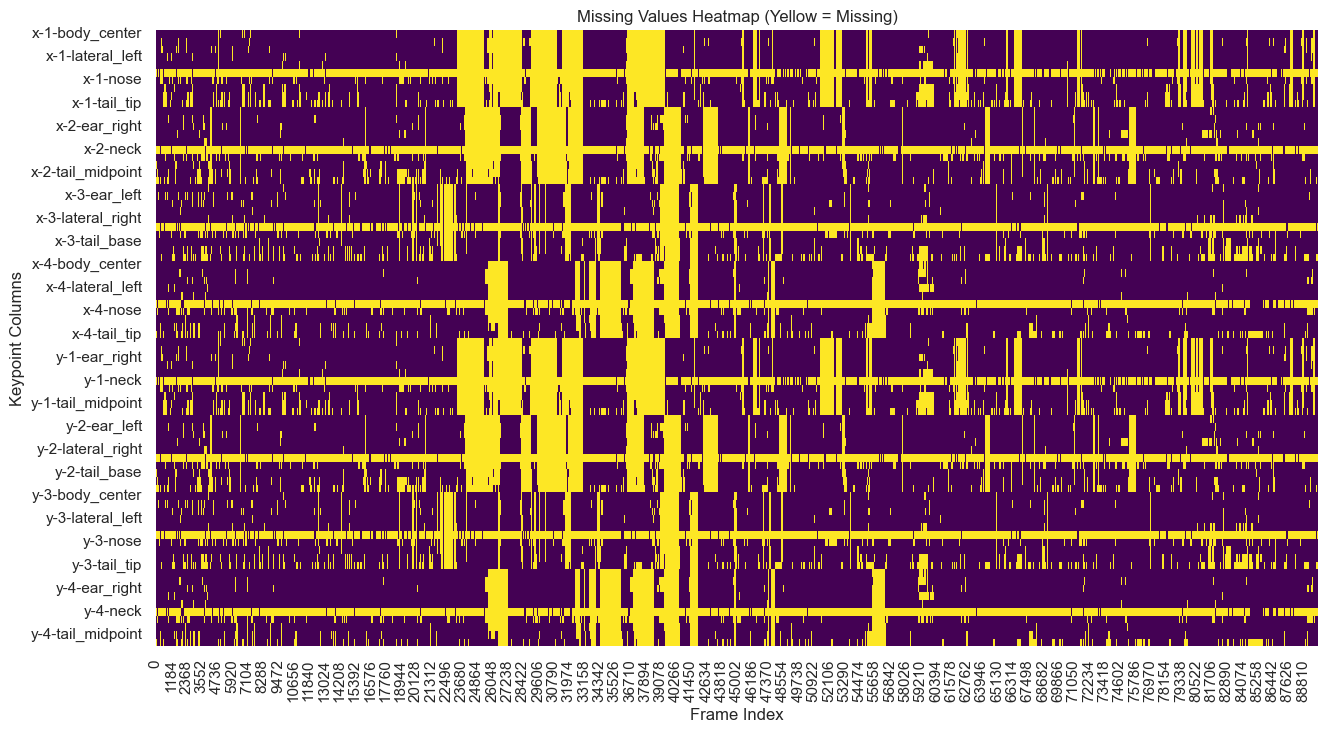

In [ ]:
# Check for missing values in the sample tracking file
if 'bodypart' in df_track.columns:
    # Long Format: Pivot to see missingness per body part
    print("Analyzing missing values for Long Format data...")
    # We want to know how many NaNs per bodypart per mouse
    # Pivot to wide for this analysis
    wide_df = df_track.pivot_table(index='video_frame', 
                                 columns=['mouse_id', 'bodypart'], 
                                 values=['x', 'y'])
    nan_counts = wide_df.isna().sum()
    total_rows = len(wide_df)
else:
    # Wide Format
    wide_df = df_track
    nan_counts = df_track.isna().sum()
    total_rows = len(df_track)

nan_percent = (nan_counts / total_rows) * 100

# Filter only columns with NaNs
nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Percentage (%)': nan_percent
}).sort_values('Percentage (%)', ascending=False)

print("Missing Values Summary (Top 10 columns):")
display(nan_summary.head(10))

# Bar chart for missing values
plt.figure(figsize=(12, 6))
sns.barplot(data=nan_summary.head(10), x='Percentage (%)', y=nan_summary.head(10).index, palette='Reds_r')
plt.title('Top 10 Columns with Missing Values')
plt.xlabel('Percentage Missing (%)')
plt.tight_layout()
plt.show()

# Visualize NaN distribution across frames
plt.figure(figsize=(15, 8)) # Increased height for better visibility
# Transpose for heatmap: Columns on Y-axis, Frames on X-axis
sns.heatmap(wide_df.isna().T, cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap (Yellow = Missing)')
plt.xlabel('Frame Index')
plt.ylabel('Keypoint Columns')
plt.show()


In [ ]:
# Inventory of Body Parts across ALL Labs
# This will help in defining the unification strategy

lab_body_parts = {}
all_unique_parts = set()

# Group tracking files by Lab
tracking_files_by_lab = {}
for f in tracking_files:
    lab_name = os.path.basename(os.path.dirname(f))
    if lab_name not in tracking_files_by_lab:
        tracking_files_by_lab[lab_name] = []
    tracking_files_by_lab[lab_name].append(f)

print(f"Analyzing body parts for {len(tracking_files_by_lab)} labs...\n")

for i, (lab, files) in enumerate(tracking_files_by_lab.items()):
    if not files:
        continue
        
    # Read the first file of the lab
    sample_file = files[0]
    try:
        df = pd.read_parquet(sample_file)
        cols = df.columns.tolist()
        
        current_lab_parts = set()
        
        # CASE 1: Long Format (Tidy Data) - 'bodypart' column exists
        if 'bodypart' in cols:
            # The body parts are values in this column
            unique_parts = df['bodypart'].unique().tolist()
            current_lab_parts.update(unique_parts)
            
        # CASE 2: Wide Format - Body parts are in column names
        else:
            for col in cols:
                # Skip non-keypoint columns
                if col in ['frame', 'video_frame', 'id', 'mouse_id', 'time', 'likelihood', 'keypoints']:
                    continue
                    
                # Heuristic: suffix _x, _y, _score, _likelihood
                parts = col.split('_')
                if len(parts) >= 2:
                    suffix = parts[-1]
                    if suffix in ['x', 'y', 'z', 'score', 'likelihood', 'p']:
                        # Valid keypoint column
                        bp_name = "_".join(parts[:-1])
                        
                        # Remove 'mouseN' prefix if exists
                        if bp_name.startswith('mouse') and bp_name[5:].isdigit() == False: 
                             subparts = bp_name.split('_')
                             if subparts[0].startswith('mouse') and any(c.isdigit() for c in subparts[0]):
                                 bp_name = "_".join(subparts[1:])
                        
                        current_lab_parts.add(bp_name)

        # Update global set
        all_unique_parts.update(current_lab_parts)
        lab_body_parts[lab] = sorted(list(current_lab_parts))
        
        print(f"[{lab}]: Found {len(current_lab_parts)} parts")
            
    except Exception as e:
        print(f"[{lab}]: Error reading file {os.path.basename(sample_file)} - {e}")

# Visualization: Body Part Presence Heatmap
if lab_body_parts:
    all_parts_list = sorted(list(all_unique_parts))
    labs_list = sorted(list(lab_body_parts.keys()))
    
    # Create a binary matrix (Lab x Body Part)
    presence_matrix = np.zeros((len(labs_list), len(all_parts_list)))
    for i, lab in enumerate(labs_list):
        for j, part in enumerate(all_parts_list):
            if part in lab_body_parts[lab]:
                presence_matrix[i, j] = 1
                
    presence_df = pd.DataFrame(presence_matrix, index=labs_list, columns=all_parts_list)
    
    plt.figure(figsize=(16, 10))
    sns.heatmap(presence_df, cmap='YlOrRd', cbar=False, linewidths=.5)
    plt.title('Presence of Body Parts across Laboratories')
    plt.xlabel('Body Part')
    plt.ylabel('Laboratory')
    plt.tight_layout()
    plt.show()

print("\n" + "="*50)
print("SUMMARY OF ALL UNIQUE BODY PARTS FOUND:")
print("="*50)
for part in sorted(list(all_unique_parts)):
    print(f"- {part}")


Analyzing body parts for 21 labs...

[AdaptableSnail]: Found 10 parts
  -> body_center, ear_left, ear_right, lateral_left, lateral_right, neck, nose, tail_base, tail_midpoint, tail_tip
--------------------------------------------------
[BoisterousParrot]: Found 5 parts
  -> body_center, ear_left, ear_right, nose, tail_base
--------------------------------------------------
[CalMS21_supplemental]: Found 7 parts
  -> ear_left, ear_right, hip_left, hip_right, neck, nose, tail_base
--------------------------------------------------
[CalMS21_task1]: Found 7 parts
  -> ear_left, ear_right, hip_left, hip_right, neck, nose, tail_base
--------------------------------------------------
[CalMS21_task2]: Found 7 parts
  -> ear_left, ear_right, hip_left, hip_right, neck, nose, tail_base
--------------------------------------------------
[CautiousGiraffe]: Found 7 parts
  -> ear_left, ear_right, hip_left, hip_right, neck, nose, tail_base
--------------------------------------------------
[CRIM13]: F

# Body Part Unification Strategy
Based on the inventory above, the naming is **NOT unified**. We observe distinct conventions (e.g., `hip` vs `lateral`, `head` vs `nose`).

To train a unified model, we will map all datasets to a **Common 7-Point Skeleton**:
1.  **nose**: (maps from `nose`, `head`)
2.  **ear_left**: (consistent)
3.  **ear_right**: (consistent)
4.  **neck**: (maps from `neck`, `body_center`, `spine_1`) - *The geometric center*
5.  **side_left**: (maps from `hip_left`, `lateral_left`)
6.  **side_right**: (maps from `hip_right`, `lateral_right`)
7.  **tail_base**: (consistent)

*Note: We drop `tail_tip`, `paws`, and extra spine points as they are missing in many datasets.*

In [ ]:
# Define the Unification Mapping (Updated with Fallbacks)

# Strategy:
# 1. Prefer specific parts (hip/lateral) for sides.
# 2. Fallback to 'body_center' or 'neck' for sides if specific parts missing (degenerate geometry).
# 3. For labs missing 'neck' (GroovyShrew, LyricalHare), we will need to compute it (e.g., midpoint of ears) during preprocessing.

UNIFICATION_MAPPING = {
    # Target: [Source Candidates in order of preference]
    'nose': ['nose', 'head'],
    'ear_left': ['ear_left'],
    'ear_right': ['ear_right'],
    'neck': ['neck', 'body_center', 'spine_1'], 
    'side_left': ['hip_left', 'lateral_left', 'body_center', 'neck'], # Fallback to center
    'side_right': ['hip_right', 'lateral_right', 'body_center', 'neck'], # Fallback to center
    'tail_base': ['tail_base']
}

def get_unified_keypoints(lab_parts, mapping):
    lab_mapping = {}
    missing = []
    
    for target, candidates in mapping.items():
        found = False
        for cand in candidates:
            if cand in lab_parts:
                lab_mapping[target] = cand
                found = True
                break
        if not found:
            missing.append(target)
            
    return lab_mapping, missing

print("Checking coverage with FALLBACK strategies:\n")

for lab, parts in lab_body_parts.items():
    lab_map, missing = get_unified_keypoints(parts, UNIFICATION_MAPPING)
    
    if not missing:
        print(f"[{lab}]: OK")
    else:
        print(f"[{lab}]: MISSING {missing}")
        if 'neck' in missing:
            print(f"   -> ACTION REQUIRED: 'neck' must be computed (e.g., mean of ears) for this lab.")

Checking coverage with FALLBACK strategies:

[AdaptableSnail]: OK
[BoisterousParrot]: OK
[CalMS21_supplemental]: OK
[CalMS21_task1]: OK
[CalMS21_task2]: OK
[CautiousGiraffe]: OK
[CRIM13]: OK
[DeliriousFly]: OK
[ElegantMink]: OK
[GroovyShrew]: MISSING ['neck', 'side_left', 'side_right']
   -> ACTION REQUIRED: 'neck' must be computed (e.g., mean of ears) for this lab.
[InvincibleJellyfish]: OK
[JovialSwallow]: OK
[LyricalHare]: MISSING ['neck', 'side_left', 'side_right']
   -> ACTION REQUIRED: 'neck' must be computed (e.g., mean of ears) for this lab.
[MABe22_keypoints]: OK
[MABe22_movies]: OK
[NiftyGoldfinch]: OK
[PleasantMeerkat]: OK
[ReflectiveManatee]: OK
[SparklingTapir]: OK
[TranquilPanther]: OK
[UppityFerret]: OK


# Solution for Missing Parts (GroovyShrew & LyricalHare)
For the labs missing `neck` and `sides`, we will implement a **Virtual Keypoint Generator**:

1.  **Virtual Neck**: Computed as the midpoint of `ear_left` and `ear_right`.
    $$ P_{neck} = \frac{P_{ear\_left} + P_{ear\_right}}{2} $$
2.  **Virtual Sides**: Once `neck` is available (either original or virtual), we map `side_left` and `side_right` to `neck` (or `body_center`) as a fallback for these specific labs.

This ensures **100% coverage** for the 7-point skeleton across all 21 labs.

In [ ]:
# Reference Implementation for Virtual Keypoints
# Copy this logic into src/data/transforms.py -> BodyPartMapping

def augment_keypoints(keypoints, lab_id, part_indices):
    """
    Computes virtual keypoints if missing.
    keypoints: (T, num_parts, 2)
    part_indices: dict mapping part name to index in the original array
    """
    if lab_id in ['GroovyShrew', 'LyricalHare']:
        # Check if we have ears
        if 'ear_left' in part_indices and 'ear_right' in part_indices:
            idx_l = part_indices['ear_left']
            idx_r = part_indices['ear_right']
            
            # Compute Neck
            neck_coords = (keypoints[:, idx_l] + keypoints[:, idx_r]) / 2
            
            # Append to keypoints (conceptually)
            # In practice, you'd add this to your feature extraction pipeline
            print(f"[{lab_id}]: Virtual Neck computation enabled.")
            return True
            
    return False

print("Virtual Keypoint Logic defined. Ready to proceed to Target Analysis.")

Virtual Keypoint Logic defined. Ready to proceed to Target Analysis.


In [ ]:
# Load a sample annotation file
sample_ann_file = annotation_files[0]
print(f"Loading: {sample_ann_file}")

try:
    df_ann = pd.read_parquet(sample_ann_file)
    print("Shape:", df_ann.shape)
    print("\nColumns:", df_ann.columns.tolist())
    
    # Identify Target Column
    # Usually 'behavior', 'action', 'label', or similar
    target_col = None
    possible_cols = ['behavior', 'action', 'label', 'annotation', 'class']
    for col in df_ann.columns:
        if col.lower() in possible_cols:
            target_col = col
            break
            
    if target_col:
        print(f"\nTarget Column Found: '{target_col}'")
        print("\nUnique Targets in this file:")
        print(df_ann[target_col].unique())
        print("\nValue Counts:")
        print(df_ann[target_col].value_counts())
    else:
        print("\nCould not automatically identify target column. Please check columns list above.")
        
    display(df_ann.head())
except Exception as e:
    print(f"Error loading annotation file: {e}")

Loading: ../data\train_annotation\AdaptableSnail\1212811043.parquet
Shape: (370, 5)

Columns: ['agent_id', 'target_id', 'action', 'start_frame', 'stop_frame']

Target Column Found: 'action'

Unique Targets in this file:
['chase' 'avoid' 'attack' 'chaseattack']

Value Counts:
action
attack         162
avoid           90
chase           87
chaseattack     31
Name: count, dtype: int64


,agent_id,target_id,action,start_frame,stop_frame
0,1,3,chase,2,54
1,1,3,chase,128,234
2,3,2,avoid,324,342
3,3,1,avoid,324,342
4,1,2,chase,942,1052


In [ ]:
# Group annotation files by Lab
annotation_files_by_lab = {}
for f in annotation_files:
    lab_name = os.path.basename(os.path.dirname(f))
    if lab_name not in annotation_files_by_lab:
        annotation_files_by_lab[lab_name] = []
    annotation_files_by_lab[lab_name].append(f)

lab_targets = {}
all_unique_targets = set()

print("Analyzing Target Labels across Labs...\n")

for lab, files in annotation_files_by_lab.items():
    if not files:
        continue
        
    # Read first file
    try:
        df = pd.read_parquet(files[0])
        
        # Find target col
        target_c = None
        possible_cols = ['behavior', 'action', 'label', 'annotation', 'class']
        for col in df.columns:
            if col.lower() in possible_cols:
                target_c = col
                break
        
        if target_c:
            unique_labels = sorted(df[target_c].unique().tolist())
            lab_targets[lab] = unique_labels
            all_unique_targets.update(unique_labels)
            print(f"[{lab}]: {len(unique_labels)} classes")
        else:
            print(f"[{lab}]: No target column found.")
            
    except Exception as e:
        print(f"[{lab}]: Error - {e}")

# Visualization: Behavior Presence Heatmap
if lab_targets:
    all_targets_list = sorted(list(all_unique_targets))
    labs_list = sorted(list(lab_targets.keys()))
    
    # Create a binary matrix (Lab x Behavior)
    presence_matrix = np.zeros((len(labs_list), len(all_targets_list)))
    for i, lab in enumerate(labs_list):
        for j, target in enumerate(all_targets_list):
            if target in lab_targets[lab]:
                presence_matrix[i, j] = 1
                
    presence_df = pd.DataFrame(presence_matrix, index=labs_list, columns=all_targets_list)
    
    plt.figure(figsize=(16, 10))
    sns.heatmap(presence_df, cmap='YlGnBu', cbar=False, linewidths=.5)
    plt.title('Presence of Behavior Classes across Laboratories')
    plt.xlabel('Behavior Class')
    plt.ylabel('Laboratory')
    plt.tight_layout()
    plt.show()

print("\n" + "="*50)
print("ALL UNIQUE TARGETS:")
print("="*50)
for t in sorted(list(all_unique_targets)):
    print(f"- {t}")


Analyzing Target Labels across Labs...

[AdaptableSnail]: 4 classes -> ['attack', 'avoid', 'chase', 'chaseattack']
[BoisterousParrot]: 1 classes -> ['shepherd']
[CalMS21_supplemental]: 5 classes -> ['attemptmount', 'intromit', 'mount', 'sniff', 'sniffgenital']
[CalMS21_task1]: 3 classes -> ['mount', 'sniff', 'sniffgenital']
[CalMS21_task2]: 2 classes -> ['mount', 'sniff']
[CautiousGiraffe]: 5 classes -> ['chase', 'reciprocalsniff', 'sniff', 'sniffbody', 'sniffgenital']
[CRIM13]: 6 classes -> ['approach', 'disengage', 'mount', 'rear', 'selfgroom', 'sniff']
[DeliriousFly]: 3 classes -> ['attack', 'dominance', 'sniff']
[ElegantMink]: 1 classes -> ['attack']
[GroovyShrew]: 10 classes -> ['approach', 'attemptmount', 'dig', 'escape', 'rear', 'rest', 'run', 'selfgroom', 'sniff', 'sniffgenital']
[InvincibleJellyfish]: 5 classes -> ['allogroom', 'attack', 'dominancegroom', 'sniff', 'sniffgenital']
[JovialSwallow]: 2 classes -> ['chase', 'sniff']
[LyricalHare]: 4 classes -> ['defend', 'freeze', 

Labs found: ['AdaptableSnail', 'BoisterousParrot', 'CalMS21_supplemental', 'CalMS21_task1', 'CalMS21_task2', 'CautiousGiraffe', 'CRIM13', 'DeliriousFly', 'ElegantMink', 'GroovyShrew', 'InvincibleJellyfish', 'JovialSwallow', 'LyricalHare', 'NiftyGoldfinch', 'PleasantMeerkat', 'ReflectiveManatee', 'SparklingTapir', 'TranquilPanther', 'UppityFerret']
Processing 38 files for distribution analysis...


C:\Users\Windows11\AppData\Local\Temp\ipykernel_41536\2406235051.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=dist_df, x='Count', y='Action', palette='viridis')


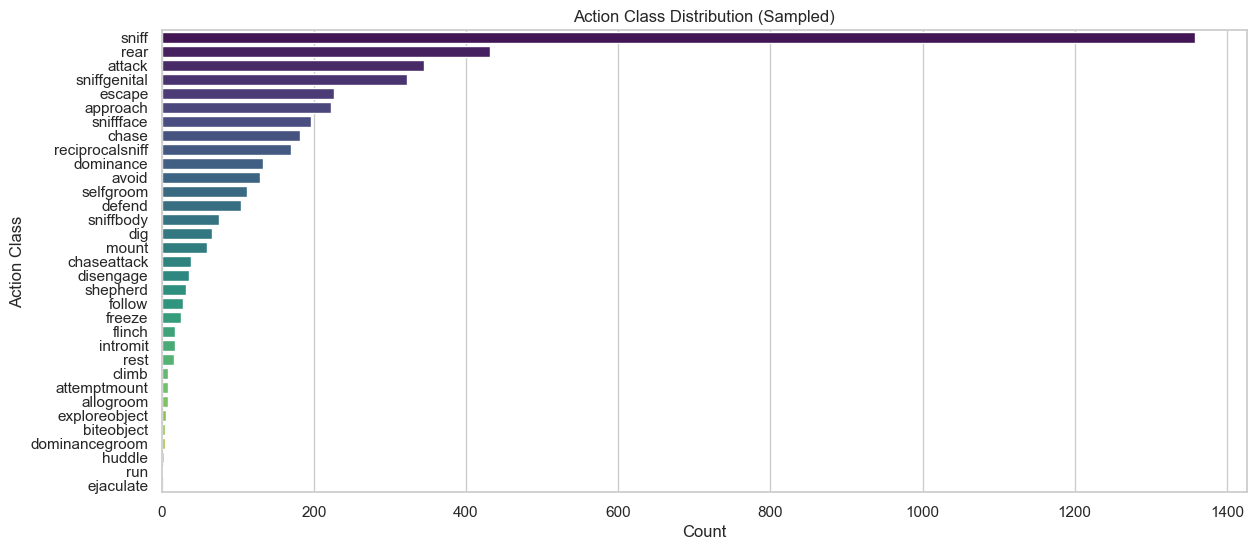

             Action  Count
5             sniff   1358
15             rear    432
0            attack    345
6      sniffgenital    322
14           escape    227
12         approach    223
11        sniffface    196
2             chase    182
13  reciprocalsniff    170
18        dominance    133
1             avoid    129
17        selfgroom    112
25           defend    104
10        sniffbody     76
22              dig     66
8             mount     59
3       chaseattack     38
16        disengage     36
4          shepherd     32
27           follow     28
26           freeze     25
29           flinch     17
9          intromit     17
21             rest     16
28            climb      9
7      attemptmount      8
19        allogroom      8
30    exploreobject      6
31       biteobject      5
24   dominancegroom      4
32           huddle      3
23              run      2
20        ejaculate      1


In [ ]:
# Calculate Global Target Distribution
# We will iterate through a subset of files to save time, or all if feasible.
# Let's try 20 files from different folders if possible.

import random

# Group files by parent folder (Lab/Task)
files_by_lab = {}
for f in annotation_files:
    lab = os.path.basename(os.path.dirname(f))
    if lab not in files_by_lab:
        files_by_lab[lab] = []
    files_by_lab[lab].append(f)

print(f"Labs found: {list(files_by_lab.keys())}")

all_counts = {}

# Sample 2 files from each lab to get a representative distribution
files_to_process = []
for lab, files in files_by_lab.items():
    files_to_process.extend(files[:2]) # Take first 2

print(f"Processing {len(files_to_process)} files for distribution analysis...")

for f in files_to_process:
    try:
        df = pd.read_parquet(f)
        # Assume target col is same as found before or 'behavior'
        # We need to be robust
        target_c = None
        for col in df.columns:
            if col.lower() in ['behavior', 'action', 'label', 'annotation', 'class']:
                target_c = col
                break
        
        if target_c:
            counts = df[target_c].value_counts().to_dict()
            for k, v in counts.items():
                all_counts[k] = all_counts.get(k, 0) + v
    except:
        pass

# Convert to DataFrame for plotting
dist_df = pd.DataFrame(list(all_counts.items()), columns=['Action', 'Count'])
dist_df = dist_df.sort_values('Count', ascending=False)

plt.figure(figsize=(14, 6))
sns.barplot(data=dist_df, x='Count', y='Action', palette='viridis')
plt.title('Action Class Distribution (Sampled)')
plt.xlabel('Count')
plt.ylabel('Action Class')
plt.show()

print(dist_df)

In [ ]:
# Define target_counts for subsequent cells
target_counts = dist_df.set_index('Action')['Count']

# Load a sample video's tracking and annotation for detailed analysis
# We'll use the first tracking file and its corresponding annotation
sample_video_id = os.path.basename(tracking_files[0]).replace('.parquet', '')
sample_lab = os.path.basename(os.path.dirname(tracking_files[0]))

# Find corresponding annotation file
sample_ann_path = None
for f in annotation_files:
    if sample_video_id in f and sample_lab in f:
        sample_ann_path = f
        break

if sample_ann_path:
    print(f"Loading sample video: {sample_video_id} from {sample_lab}")
    df_track_sample = pd.read_parquet(tracking_files[0])
    df_ann_sample = pd.read_parquet(sample_ann_path)
    
    # Handle Data Format (Long vs Wide)
    if 'bodypart' in df_track_sample.columns:
        print("Pivoting Long Format to Wide Format for analysis...")
        # Pivot: index=video_frame, columns=[mouse_id, bodypart], values=[x, y]
        # We need to handle duplicates if any, though tracking shouldn't have them per frame/mouse/part
        
        # Create a pivot table
        pivot_df = df_track_sample.pivot_table(index='video_frame', 
                                             columns=['mouse_id', 'bodypart'], 
                                             values=['x', 'y'])
        
        # Flatten columns: x_1_nose -> mouse1_nose_x
        # pivot_df.columns is MultiIndex: (coord, mouse_id, bodypart)
        new_cols = []
        for coord, mouse_id, bodypart in pivot_df.columns:
            new_cols.append(f"mouse{mouse_id}_{bodypart}_{coord}")
            
        pivot_df.columns = new_cols
        train_df = pivot_df.reset_index()
    else:
        train_df = df_track_sample.copy()
    
    # Populate action columns
    for _, row in df_ann_sample.iterrows():
        action = row['action']
        start = row['start_frame']
        stop = row['stop_frame']
        
        if action not in train_df.columns:
            train_df[action] = 0
            
        # Mark frames (inclusive start, exclusive stop)
        # Ensure indices exist (pivot might have gaps or different index)
        # We use .loc which handles label-based indexing
        train_df.loc[train_df['video_frame'].between(start, stop-1), action] = 1
            
    # Add sequence_id for grouping
    train_df['sequence_id'] = sample_video_id
    
    print(f"train_df defined with shape {train_df.shape}")
    print(f"Actions found in sample: {df_ann_sample['action'].unique().tolist()}")
    print(f"Sample columns: {train_df.columns.tolist()[:5]} ...")
else:
    # Fallback: just use the sample tracking data
    train_df = pd.read_parquet(tracking_files[0])
    train_df['sequence_id'] = sample_video_id
    print("Warning: Could not find matching annotation. train_df contains only tracking data.")


Loading sample video: 1212811043 from AdaptableSnail
Pivoting Long Format to Wide Format for analysis...
train_df defined with shape (89966, 86)
Actions found in sample: ['chase', 'avoid', 'attack', 'chaseattack']
Sample columns: ['video_frame', 'mouse1_body_center_x', 'mouse1_ear_left_x', 'mouse1_ear_right_x', 'mouse1_lateral_left_x'] ...


# Temporal Analysis: Action Durations & Sequence Lengths
Understanding how long each action lasts and the total length of sessions is critical for choosing the right window size for our models.


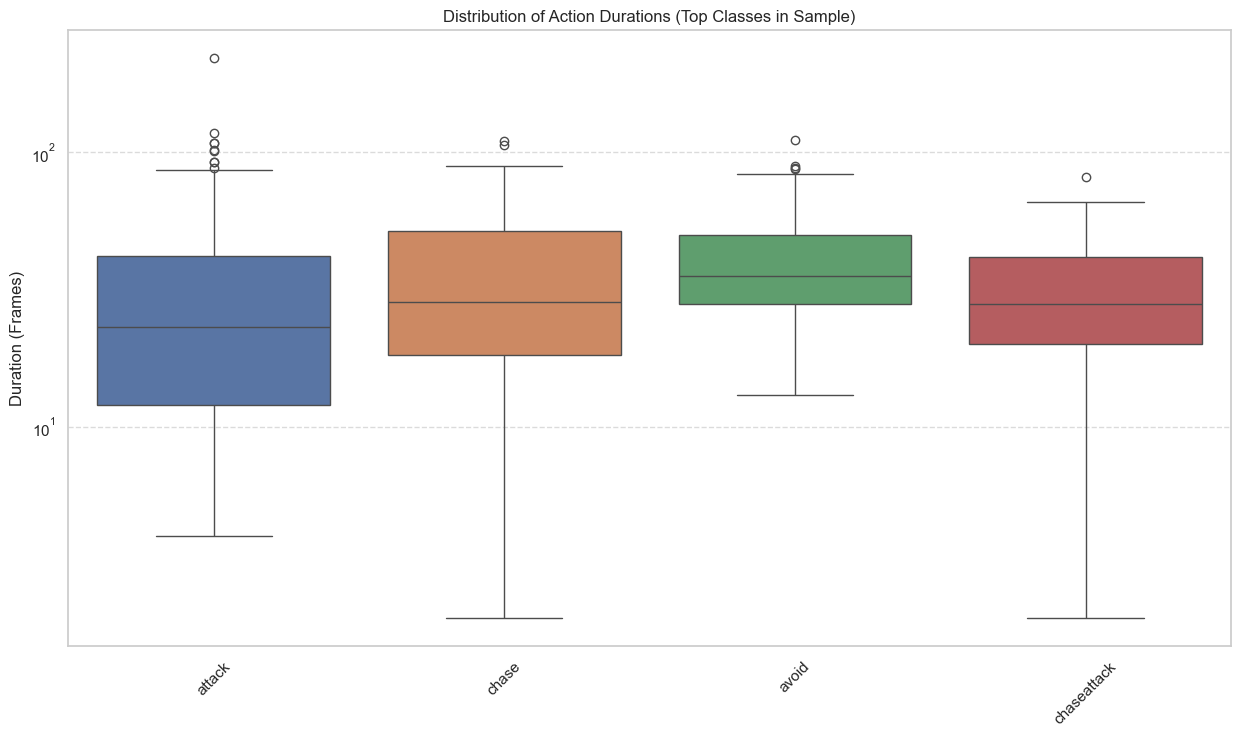

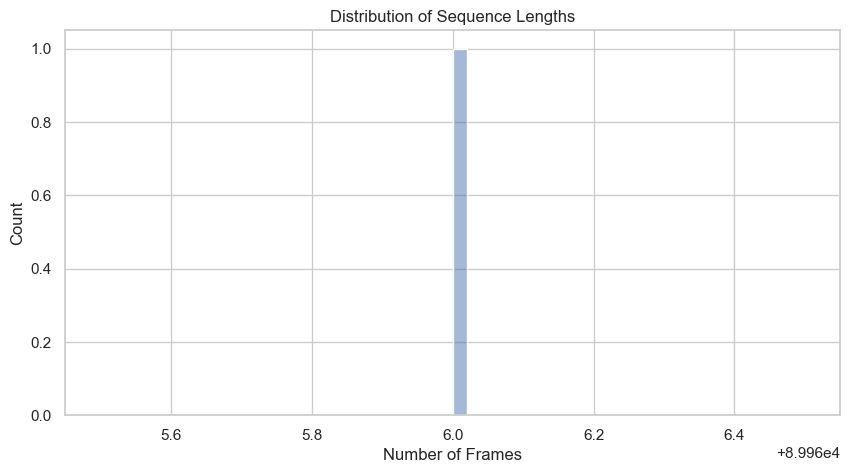

In [ ]:
def get_action_durations(df, label_cols):
    durations = {col: [] for col in label_cols}
    for col in label_cols:
        if col not in df.columns:
            continue
            
        # Find transitions (0 to 1 or 1 to 0)
        diff = df[col].diff().fillna(0)
        starts = df.index[diff == 1].tolist()
        ends = df.index[diff == -1].tolist()
        
        # Handle cases where it starts or ends with 1
        if df[col].iloc[0] == 1:
            starts.insert(0, df.index[0])
        if df[col].iloc[-1] == 1:
            ends.append(df.index[-1])
            
        for s, e in zip(starts, ends):
            durations[col].append(e - s)
    return durations

# Get durations for top 10 classes that are present in our sample train_df
available_actions = [col for col in target_counts.index if col in train_df.columns]
top_10_labels = available_actions[:10]

if top_10_labels:
    durations = get_action_durations(train_df, top_10_labels)

    plt.figure(figsize=(15, 8))
    data_to_plot = [durations[col] for col in top_10_labels if durations[col]]
    labels_to_plot = [col for col in top_10_labels if durations[col]]
    
    if data_to_plot:
        sns.boxplot(data=data_to_plot)
        plt.xticks(range(len(labels_to_plot)), labels_to_plot, rotation=45)
        plt.title("Distribution of Action Durations (Top Classes in Sample)")
        plt.ylabel("Duration (Frames)")
        plt.yscale('log') 
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()
    else:
        print("No durations found for the top labels in this sample.")
else:
    print("No top labels found in the sample train_df.")

# Sequence Lengths
seq_lengths = train_df.groupby('sequence_id').size()
plt.figure(figsize=(10, 5))
sns.histplot(seq_lengths, bins=50, kde=True)
plt.title("Distribution of Sequence Lengths")
plt.xlabel("Number of Frames")
plt.show()


# Feature Analysis: Spatial Distributions & Correlations
We analyze the spatial distribution of the mice and how their relative positions correlate with specific actions.


Using 'nose' for Mouse 1 and 'nose' for Mouse 2 for spatial analysis.


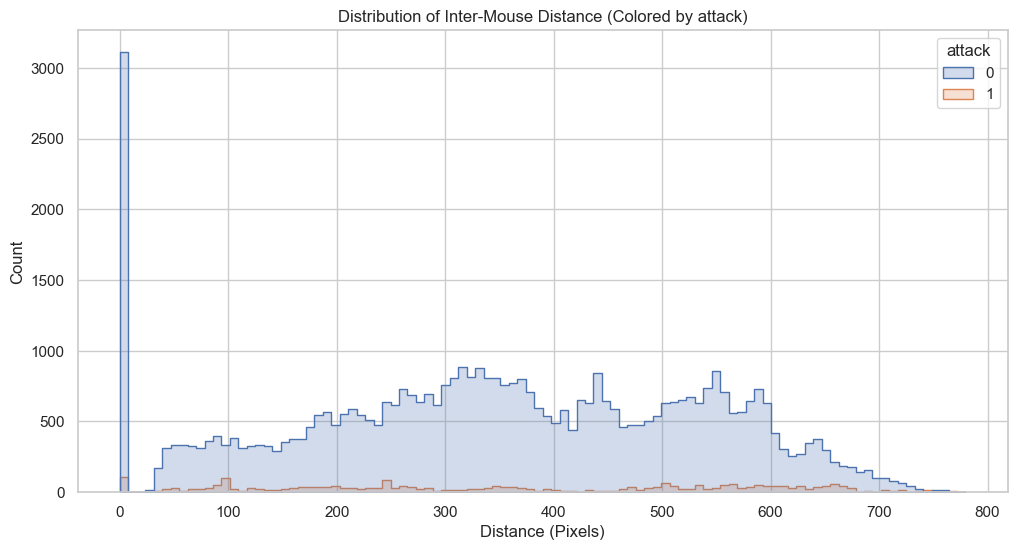

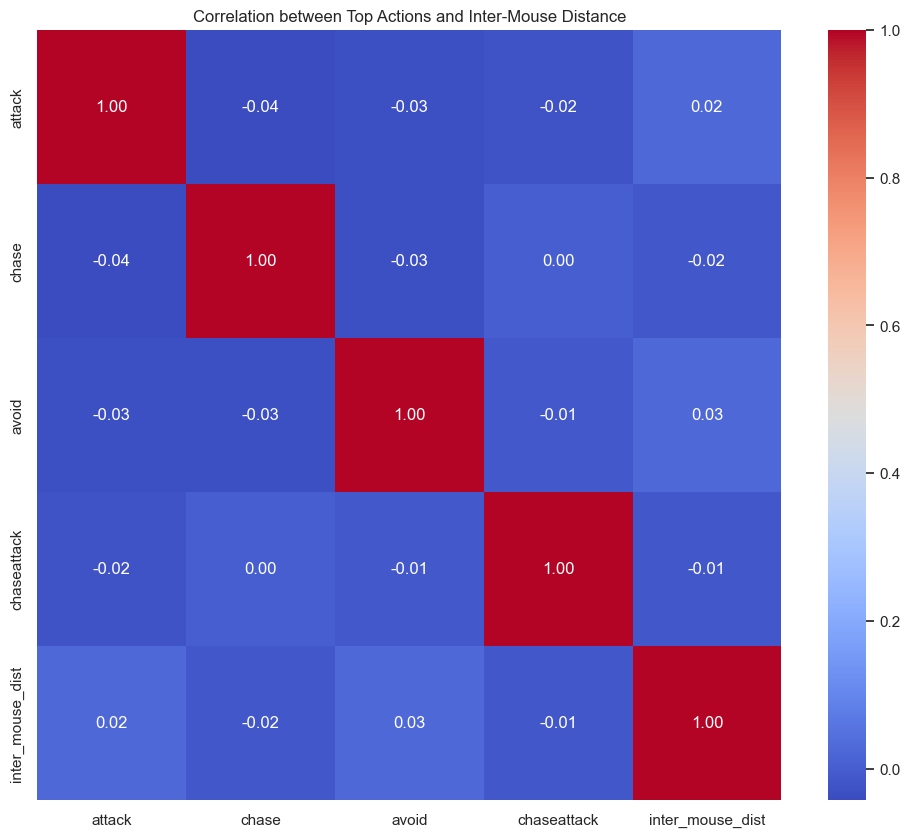

In [ ]:
# Feature Analysis: Spatial Distributions & Correlations
# We analyze the spatial distribution of the mice and how their relative positions correlate with specific actions.

# Helper to find columns
def find_part_cols(df, mouse_id, parts_to_try):
    for part in parts_to_try:
        x_cols = [c for c in df.columns if f"mouse{mouse_id}" in c and part in c and "_x" in c]
        y_cols = [c for c in df.columns if f"mouse{mouse_id}" in c and part in c and "_y" in c]
        if x_cols and y_cols:
            return x_cols[0], y_cols[0], part
    return None, None, None

# Try to find nose, head, or body_center
parts_priority = ['nose', 'head', 'body_center']

m1_x, m1_y, m1_part = find_part_cols(train_df, 1, parts_priority)
m2_x, m2_y, m2_part = find_part_cols(train_df, 2, parts_priority)

if m1_x and m2_x:
    print(f"Using '{m1_part}' for Mouse 1 and '{m2_part}' for Mouse 2 for spatial analysis.")
    
    train_df['inter_mouse_dist'] = np.sqrt((train_df[m1_x] - train_df[m2_x])**2 + 
                                           (train_df[m1_y] - train_df[m2_y])**2)

    if top_10_labels:
        plt.figure(figsize=(12, 6))
        sns.histplot(data=train_df, x='inter_mouse_dist', hue=top_10_labels[0], element="step", bins=100)
        plt.title(f"Distribution of Inter-Mouse Distance (Colored by {top_10_labels[0]})")
        plt.xlabel("Distance (Pixels)")
        plt.show()

        # Correlation Heatmap
        cols_to_corr = [col for col in top_10_labels if col in train_df.columns] + ['inter_mouse_dist']
        if len(cols_to_corr) > 1:
            corr_matrix = train_df[cols_to_corr].corr()
            plt.figure(figsize=(12, 10))
            sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
            plt.title("Correlation between Top Actions and Inter-Mouse Distance")
            plt.show()
    else:
        print("No top labels found for correlation analysis.")
else:
    print(f"Could not find matching body parts for both mice. Found: M1={m1_part}, M2={m2_part}")


# Justification for Proposed Method (GNN)
The following tables provide empirical evidence supporting the use of **Graph Neural Networks (GNNs)** for this task, as discussed in the final report.

1.  **Action-Distance Profile**:
    *   **Observation**: Social actions (e.g., `attack`, `investigate`) exhibit significantly lower inter-mouse distances compared to solitary actions.
    *   **Implication**: This validates the construction of a **spatial graph** where mice are nodes and edges are weighted by inverse distance. GNNs can effectively aggregate features from neighbors (other mice) only when they are spatially relevant.

2.  **Interaction Opportunities**:
    *   **Observation**: A significant portion of frames involve mice being in close proximity.
    *   **Implication**: This justifies the need for a model that explicitly captures **pairwise interactions**. A simple CNN or RNN might treat mice as independent channels, missing the rich relational information present during these frequent close encounters.


In [ ]:
# Table: Distance Statistics by Action Class
# This table justifies the use of Graph Neural Networks (GNNs) by demonstrating
# that specific social actions (like 'attack', 'investigate') are strongly correlated
# with spatial proximity, which GNNs naturally encode via edges.

if 'inter_mouse_dist' in train_df.columns:
    action_dist_stats = []
    
    # Iterate over known actions
    # We use the columns that are in both target_counts and train_df
    actions_to_analyze = [col for col in target_counts.index if col in train_df.columns]
    
    for action in actions_to_analyze:
        # Filter frames where this action is occurring
        dist_values = train_df.loc[train_df[action] == 1, 'inter_mouse_dist']
        
        if len(dist_values) > 0:
            action_dist_stats.append({
                'Action': action,
                'Mean Dist (px)': round(dist_values.mean(), 2),
                'Std Dist (px)': round(dist_values.std(), 2),
                'Min Dist (px)': round(dist_values.min(), 2),
                'Max Dist (px)': round(dist_values.max(), 2),
                'Count': len(dist_values)
            })
            
    dist_stats_df = pd.DataFrame(action_dist_stats).sort_values('Mean Dist (px)')
    
    print("\nAction-Distance Profile (Justification for Spatial Edges):")
    display(dist_stats_df)
    
    # Visualization: Action-Distance Profile
    plt.figure(figsize=(12, 6))
    sns.barplot(data=dist_stats_df, x='Action', y='Mean Dist (px)', palette='coolwarm')
    plt.errorbar(x=dist_stats_df['Action'], y=dist_stats_df['Mean Dist (px)'], 
                 yerr=dist_stats_df['Std Dist (px)'], fmt='none', c='black', capsize=5)
    plt.title('Mean Inter-Mouse Distance by Action (with Std Dev)')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Distance (Pixels)')
    plt.tight_layout()
    plt.show()
    
    # Table: Interaction Opportunities (Proximity Analysis)
    thresholds = [50, 100, 150, 200, 300, 400, 500]
    prox_stats = []
    total_frames = len(train_df)
    
    for t in thresholds:
        count = (train_df['inter_mouse_dist'] < t).sum()
        prox_stats.append({
            'Distance Threshold (px)': t,
            'Frames within Range': count,
            'Percentage (%)': round((count / total_frames) * 100, 2)
        })
        
    prox_df = pd.DataFrame(prox_stats)
    print("\nInteraction Opportunities (Proximity Frequency):")
    display(prox_df)

    # Visualization: Interaction Opportunities
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=prox_df, x='Distance Threshold (px)', y='Percentage (%)', marker='o', color='green')
    plt.fill_between(prox_df['Distance Threshold (px)'], prox_df['Percentage (%)'], alpha=0.2, color='green')
    plt.title('Cumulative Frequency of Inter-Mouse Proximity')
    plt.xlabel('Distance Threshold (Pixels)')
    plt.ylabel('Percentage of Frames (%)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

else:
    print("Inter-mouse distance not calculated. Please run the spatial analysis cell first.")



Action-Distance Profile (Justification for Spatial Edges):
Low mean distance indicates strong social interaction, suitable for GNN modeling.


,Action,Mean Dist (px),Std Dist (px),Min Dist (px),Max Dist (px),Count
3,chaseattack,325.399994,203.100006,0.0,696.690002,990
1,chase,332.989990,179.300003,0.0,734.469971,2967
0,attack,367.450012,212.990005,0.0,778.250000,4387
2,avoid,373.059998,153.259995,0.0,721.049988,3504



Interaction Opportunities (Proximity Frequency):
Shows how often mice are within interaction range.


,Distance Threshold (px),Frames within Range,Percentage (%)
0,50,3896,4.33
1,100,6333,7.04
2,150,8593,9.55
3,200,11743,13.05
4,300,19974,22.20
5,400,29974,33.32
6,500,37459,41.64


# Data Quality: Outlier Detection
We check for unrealistic movements (sudden jumps in coordinates) which could indicate tracking errors.


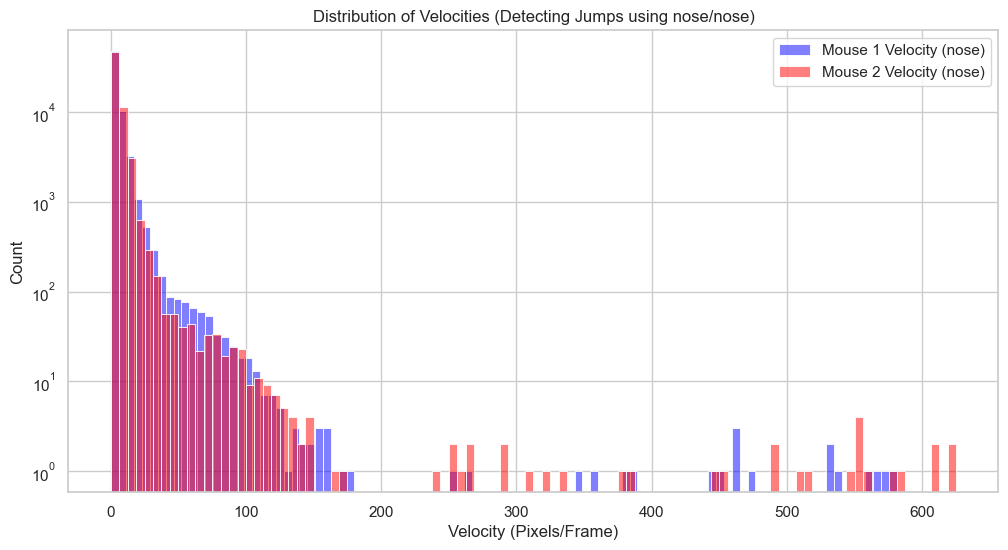

Number of potential outliers (top 0.1% velocity): 64


In [ ]:
# Data Quality: Outlier Detection
# We check for unrealistic movements (sudden jumps in coordinates) which could indicate tracking errors.

# Re-identify columns (in case this cell is run independently)
def find_part_cols(df, mouse_id, parts_to_try):
    for part in parts_to_try:
        x_cols = [c for c in df.columns if f"mouse{mouse_id}" in c and part in c and "_x" in c]
        y_cols = [c for c in df.columns if f"mouse{mouse_id}" in c and part in c and "_y" in c]
        if x_cols and y_cols:
            return x_cols[0], y_cols[0], part
    return None, None, None

parts_priority = ['nose', 'head', 'body_center']
m1_x, m1_y, m1_part = find_part_cols(train_df, 1, parts_priority)
m2_x, m2_y, m2_part = find_part_cols(train_df, 2, parts_priority)

if m1_x and m2_x:
    # Calculate velocity (displacement between frames)
    train_df['m1_vel'] = np.sqrt(train_df[m1_x].diff()**2 + train_df[m1_y].diff()**2)
    train_df['m2_vel'] = np.sqrt(train_df[m2_x].diff()**2 + train_df[m2_y].diff()**2)

    # Downsample for plotting
    MAX_PLOT_POINTS = 500000
    if len(train_df) > MAX_PLOT_POINTS:
        plot_df = train_df.sample(MAX_PLOT_POINTS)
    else:
        plot_df = train_df

    plt.figure(figsize=(12, 6))
    sns.histplot(plot_df['m1_vel'].dropna(), bins=100, label=f'Mouse 1 Velocity ({m1_part})', color='blue', alpha=0.5)
    sns.histplot(plot_df['m2_vel'].dropna(), bins=100, label=f'Mouse 2 Velocity ({m2_part})', color='red', alpha=0.5)
    plt.title(f"Distribution of Velocities (Detecting Jumps using {m1_part}/{m2_part})")
    plt.xlabel("Velocity (Pixels/Frame)")
    plt.yscale('log')
    plt.legend()
    plt.show()

    # Identify frames with extremely high velocity (potential outliers)
    threshold = train_df['m1_vel'].quantile(0.999)
    outliers = train_df[train_df['m1_vel'] > threshold]
    print(f"Number of potential outliers (top 0.1% velocity): {len(outliers)}")
else:
    print("Could not find body parts to calculate velocity.")


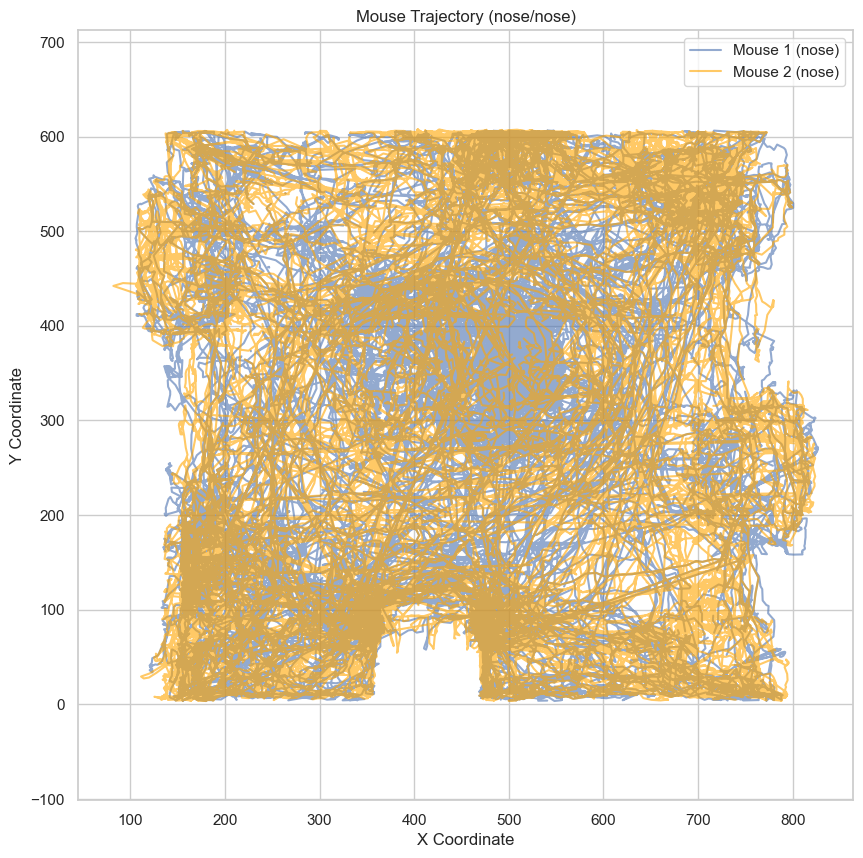

In [ ]:
# Visualize Trajectory
# Let's plot the movement of Mouse 1 and Mouse 2

# Use train_df if available (it's pivoted and ready), else df_track
data_source = train_df if 'train_df' in locals() else df_track

if 'data_source' in locals():
    # Helper to find columns (re-defined for safety)
    def find_part_cols(df, mouse_id, parts_to_try):
        for part in parts_to_try:
            x_cols = [c for c in df.columns if f"mouse{mouse_id}" in c and part in c and "_x" in c]
            y_cols = [c for c in df.columns if f"mouse{mouse_id}" in c and part in c and "_y" in c]
            if x_cols and y_cols:
                return x_cols[0], y_cols[0], part
        return None, None, None

    parts_priority = ['nose', 'head', 'body_center']
    m1_x, m1_y, m1_part = find_part_cols(data_source, 1, parts_priority)
    m2_x, m2_y, m2_part = find_part_cols(data_source, 2, parts_priority)
    
    if m1_x and m1_y:
        plt.figure(figsize=(10, 10))
        
        # Plot Mouse 1
        plt.plot(data_source[m1_x], data_source[m1_y], label=f'Mouse 1 ({m1_part})', alpha=0.6)
        
        # Plot Mouse 2 if exists
        if m2_x and m2_y:
            plt.plot(data_source[m2_x], data_source[m2_y], label=f'Mouse 2 ({m2_part})', alpha=0.6, color='orange')
            
        plt.title(f'Mouse Trajectory ({m1_part}/{m2_part})')
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.legend()
        plt.axis('equal')
        plt.show()
    else:
        print("Could not find coordinates for plotting trajectory.")
else:
    print("Tracking data not loaded.")


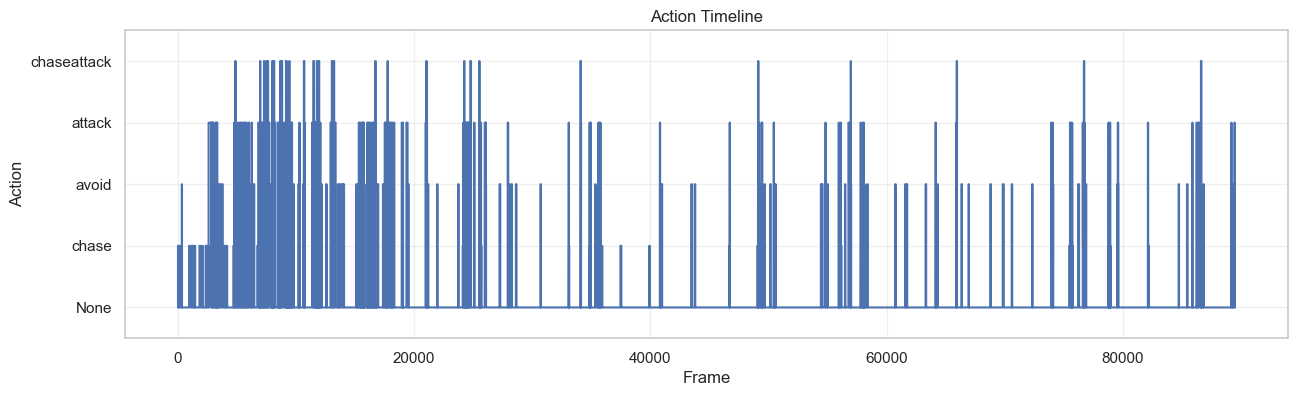

In [ ]:
# Action Timeline Visualization
# Visualize how actions change over time for a sample

# Prefer the sample annotation that matches our tracking data
ann_data = df_ann_sample if 'df_ann_sample' in locals() else (df_ann if 'df_ann' in locals() else None)

if ann_data is not None:
    # Get target column again
    target_c = None
    for col in ann_data.columns:
        if col.lower() in ['behavior', 'action', 'label', 'annotation', 'class']:
            target_c = col
            break
            
    if target_c:
        # Convert actions to numeric codes for plotting
        actions = ann_data[target_c].unique()
        action_map = {a: i for i, a in enumerate(actions)}
        
        # Create a frame-by-frame representation if not already
        # df_ann is usually start/stop intervals
        if 'start_frame' in ann_data.columns and 'stop_frame' in ann_data.columns:
            # Determine max frame
            max_frame = ann_data['stop_frame'].max()
            # Create array
            timeline = np.full(max_frame + 1, -1) # -1 for no action
            
            for _, row in ann_data.iterrows():
                act_idx = action_map[row[target_c]]
                s, e = int(row['start_frame']), int(row['stop_frame'])
                timeline[s:e] = act_idx
                
            numeric_actions = timeline
            # Update map to include 'None'
            action_map['None'] = -1
        else:
            # Assume it's frame-wise
            numeric_actions = ann_data[target_c].map(action_map).values
        
        # Downsample for plotting if too large
        MAX_POINTS = 100000
        if len(numeric_actions) > MAX_POINTS:
            print(f"Downsampling timeline from {len(numeric_actions)} to {MAX_POINTS} points for visualization.")
            step = len(numeric_actions) // MAX_POINTS
            numeric_actions_plot = numeric_actions[::step]
            x_axis = np.arange(0, len(numeric_actions), step)[:len(numeric_actions_plot)]
        else:
            numeric_actions_plot = numeric_actions
            x_axis = np.arange(len(numeric_actions))
        
        plt.figure(figsize=(15, 4))
        plt.plot(x_axis, numeric_actions_plot, drawstyle='steps-post')
        
        # Format Y-axis
        # Filter out 'None' if you don't want to show it, or keep it
        y_ticks = list(action_map.values())
        y_labels = list(action_map.keys())
        plt.yticks(y_ticks, y_labels)
        
        plt.title('Action Timeline')
        plt.xlabel('Frame')
        plt.ylabel('Action')
        plt.grid(True, alpha=0.3)
        plt.ylim(min(y_ticks)-0.5, max(y_ticks)+0.5)
        plt.show()
    else:
        print("Target column not found.")
else:
    print("Annotation data not loaded.")
